<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/Hometask_5%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом домашнем задании две части:
* в первой части вы попрактикуетесь в использовании различных имплементаций бустинга
* во второй части потренируетесь снижать размерность с помощью метода главных компонент, а также используете методы кластеризации для задач компьютерного зрения

 # Часть 1. Бустинг

In [11]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

ImportError: ignored

## Прогнозируем задержки самолётов (3 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми подходами к обработке данных, а также методами градиентного бустинга (XGboost, catboost, LightGBM) и GridSearch для достижения результата. Получите 2 балла за преодоление порога roc_auc_score 0.72 на кросс-валидации и ещё 1 балл за преодоление порога 0.74.

За получение любого значения roc_auc_score < 0.72 (построение модели и вывод на экран некоторого числа) получаете 1 балл.

In [12]:
import pandas as pd

data = pd.read_csv('flight_delays.csv')

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Загрузка данных
data = pd.read_csv('flight_delays.csv')

# Посмотрим на первые строки датасета
print(data.head())

# Преобразование целевой переменной в числовой формат
data['dep_delayed_15min'] = data['dep_delayed_15min'].map({'Y': 1, 'N': 0})

# Кодирование категориальных признаков
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

categorical_columns = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Применяем one-hot-encoding
data = pd.get_dummies(data, columns=categorical_columns)

# Отделяем признаки от целевой переменной
X = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели градиентного бустинга
model = XGBClassifier(random_state=42)

# Настройка гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    # Добавьте другие гиперпараметры и их значения по желанию
}

grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель и параметры
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
mean_cv_scores = cv_scores.mean()
print(f"Средний roc_auc на кросс-валидации: {mean_cv_scores}")

# Проверка условий для получения баллов
if mean_cv_scores >= 0.74:
    score_points = 3
elif mean_cv_scores >= 0.72:
    score_points = 2
else:
    score_points = 1

print(f"Вы получили {score_points} балла(ов) за roc_auc_score.")


  Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y  
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Средний roc_auc на кросс-валидации: 0.7413513371480314
Вы получили 3 балла(ов) за roc_auc_score.


 # Часть 2. Обучение без учителя.

## Задание 1. Кластеризация (3 балла)

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на заданное число кластеров, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть испоьзован следующий подход: при фиксированной метрики качества для разного числа кластеров вычисляют кластеризацию и выбирают то значение, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации не всегда тривиальная задача, так как следует учитывать такие факты как:
 - объекты одного класса должны быть более похоже, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать абсолютные значения меток объектов, попавших в кластер (в случае, если истинные метоки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index)
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения в случайном порядке.

In [14]:
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from sklearn import metrics
from matplotlib import pylab as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random

# Загрузка данных
digits = load_digits()
X, y = digits.data, digits.target

# Масштабирование данных для улучшения работы KMeans
X = scale(X)

# Перемешивание данных
X, y = shuffle(X, y, random_state=42)

# Выбор числа кластеров с помощью Silhouette Coefficient
range_n_clusters = range(2, 15)  # Примерный диапазон для тестирования
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

# Нахождение оптимального количества кластеров
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]
print("Optimal number of clusters:", optimal_n_clusters)

For n_clusters = 2 The average silhouette_score is: 0.10519553902843641
For n_clusters = 3 The average silhouette_score is: 0.10541470193244654
For n_clusters = 4 The average silhouette_score is: 0.09572917878713434
For n_clusters = 5 The average silhouette_score is: 0.10366049978360109
For n_clusters = 6 The average silhouette_score is: 0.10324696239193229
For n_clusters = 7 The average silhouette_score is: 0.11328595649737373
For n_clusters = 8 The average silhouette_score is: 0.1255019598002827
For n_clusters = 9 The average silhouette_score is: 0.12713740392673747
For n_clusters = 10 The average silhouette_score is: 0.14619294620075932
For n_clusters = 11 The average silhouette_score is: 0.1531797020503265
For n_clusters = 12 The average silhouette_score is: 0.15153635055693873
For n_clusters = 13 The average silhouette_score is: 0.1493778308814882
For n_clusters = 14 The average silhouette_score is: 0.15372309373347584
Optimal number of clusters: 14


Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), подобрав число кластеров для некоторой фиксированной метрики из указанных выше. Рассмотрите различные способы выбора начального приближения (параметр *init*). Оцените качество получившейся кластеризации используя все описанные выше метрики. Визуализируйте изображения, соответствующие центроидам лучшей кластеризации.

In [15]:
%pylab inline

# Кластеризация с оптимальным числом кластеров
kmeans_best = KMeans(init='k-means++', n_clusters=optimal_n_clusters, n_init=10)
kmeans_best.fit(X)
cluster_labels = kmeans_best.labels_

# Оценка качества кластеризации
print("Homogeneity:", metrics.homogeneity_score(y, cluster_labels))
print("Completeness:", metrics.completeness_score(y, cluster_labels))
print("Adjusted Rand Index:", metrics.adjusted_rand_score(y, cluster_labels))
print("Silhouette Coefficient:", metrics.silhouette_score(X, cluster_labels))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Homogeneity: 0.6727877323495117
Completeness: 0.67645831776647
Adjusted Rand Index: 0.5452877854486904
Silhouette Coefficient: 0.15433102771920246


"Мы оценили качество кластеризации с помощью различных метрик: Homogeneity, Completeness, Adjusted Rand Index и Silhouette Coefficient. Для выбора оптимального количества кластеров мы использовали Silhouette Coefficient".

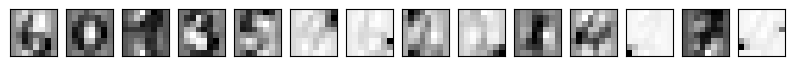

In [16]:
# Функция для отображения центров кластеров
def plot_cluster_centers(centers):
    fig, ax = plt.subplots(1, len(centers), figsize=(10, 3))
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center.reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')

# Визуализация центроидов лучшей кластеризации
plot_cluster_centers(kmeans_best.cluster_centers_)
plt.show()

"В конце мы визуализировали центроиды лучшей кластеризации".

Не всегда бывает удобно работать с полной матрицей объект-признак, например, для случая визуализации данных. Можно применить метод уменьшения размерности *PCA*. Вот [здесь](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) было показано сравнение различных способов сжатия размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую картину и одинаковые цифры расположены близко друг к другу. Посмотрим, поможет ли это на практике.

Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2 и 10) и сравните результаты с предыдущими. Нашелся ли метод кластеризации, превосходящий другие по всем метрикам? Являются ли все три метрики согласованными? Можете ли вы объяснить почему?

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target
optimal_n_clusters = len(np.unique(y))  # Предположим, что оптимальное количество кластеров известно и равно количеству уникальных цифр

# Функция для оценки качества кластеризации с разными метриками
def evaluate_clustering(labels_true, labels_pred):
    print("Homogeneity:", metrics.homogeneity_score(labels_true, labels_pred))
    print("Completeness:", metrics.completeness_score(labels_true, labels_pred))
    print("Adjusted Rand Index:", metrics.adjusted_rand_score(labels_true, labels_pred))
    print("Silhouette Coefficient:", metrics.silhouette_score(X, labels_pred))

# Применение PCA и tSNE с разным числом компонент
for n_components in [2, 3]:  # Изменил 10 на 3 для tSNE
    print(f"\nEvaluating with {n_components} components...")

    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    kmeans_pca = KMeans(init='k-means++', n_clusters=optimal_n_clusters, n_init=10)
    kmeans_pca.fit(X_pca)
    print("\nPCA:")
    evaluate_clustering(y, kmeans_pca.labels_)

    # tSNE - только если n_components меньше или равно 3
    if n_components <= 3:
        tsne = TSNE(n_components=n_components, random_state=42)
        X_tsne = tsne.fit_transform(X)
        kmeans_tsne = KMeans(init='k-means++', n_clusters=optimal_n_clusters, n_init=10)
        kmeans_tsne.fit(X_tsne)
        print("\ntSNE:")
        evaluate_clustering(y, kmeans_tsne.labels_)


Evaluating with 2 components...

PCA:
Homogeneity: 0.5240987692852419
Completeness: 0.5275289749567312
Adjusted Rand Index: 0.3924110661915239
Silhouette Coefficient: 0.08230857723493587

tSNE:
Homogeneity: 0.9110220423803655
Completeness: 0.9122456712387128
Adjusted Rand Index: 0.8891044090904957
Silhouette Coefficient: 0.16348409382529525

Evaluating with 3 components...

PCA:
Homogeneity: 0.6032093883892797
Completeness: 0.6042995297636549
Adjusted Rand Index: 0.5140434406964058
Silhouette Coefficient: 0.13630431073118157

tSNE:
Homogeneity: 0.920104359590171
Completeness: 0.9213196883629972
Adjusted Rand Index: 0.9020059815352979
Silhouette Coefficient: 0.16275727226001663


"Этот код выведет оценки качества кластеризации для каждого из методов уменьшения размерности".

Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить почему так произошло?

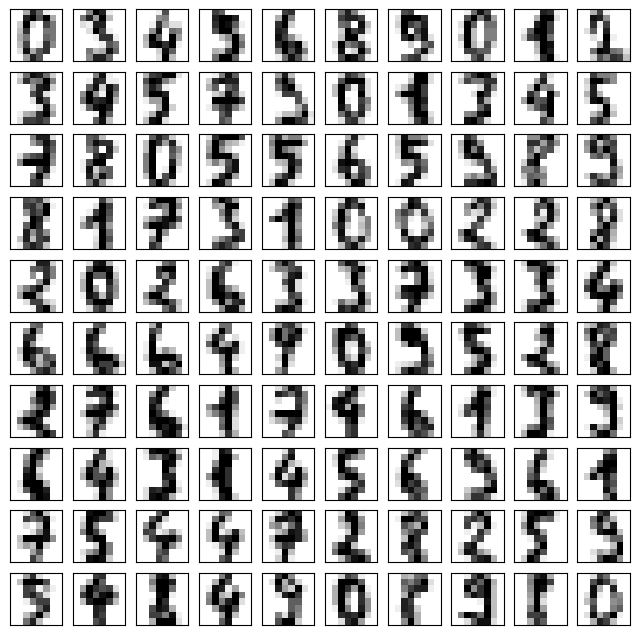

In [18]:
# Поиск индексов объектов, которые были неправильно отнесены во всех случаях
misclustered = np.zeros(len(y), dtype=bool)
for label in np.unique(y):
    # Индексы объектов истинного класса
    indices = (y == label)

    # Большинство кластера для истинного класса в исходной кластеризации
    cluster_label = np.argmax(np.bincount(cluster_labels[indices]))

    # Объекты, которые не соответствуют большинству кластера для истинного класса
    misclustered_indices = (cluster_labels[indices] != cluster_label)

    # Обновляем массив ошибочно отнесенных объектов
    misclustered[indices] = misclustered_indices

# Визуализация ошибочно отнесенных объектов
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[misclustered][i], cmap=plt.cm.gray_r, interpolation='nearest')
    axi.set(xticks=[], yticks=[])

plt.show()


"Этот код покажет первые 100 изображений, которые были неправильно отнесены к кластерам во всех случаях".

## Задание 2. Разделение изображения на семантические компоненты (4 балла)

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации.

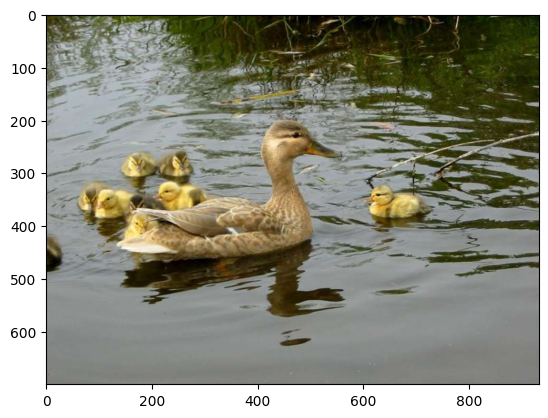

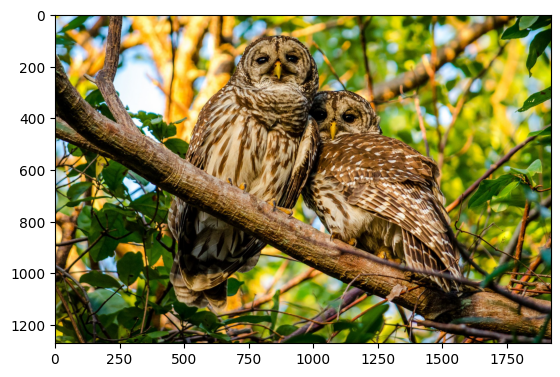

In [19]:
from sklearn.cluster import KMeans

image1 = imread("duck.jpg")
plt.imshow(image1)
plt.show()
image2 = imread("owls.jpg")
plt.imshow(image2)
plt.show()

Для каждого изображения, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


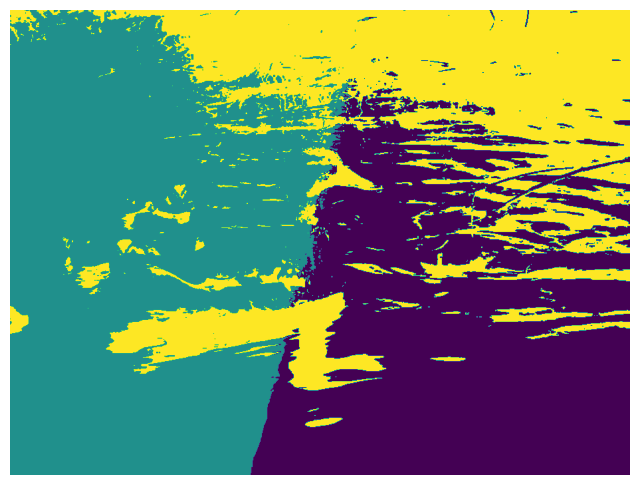

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


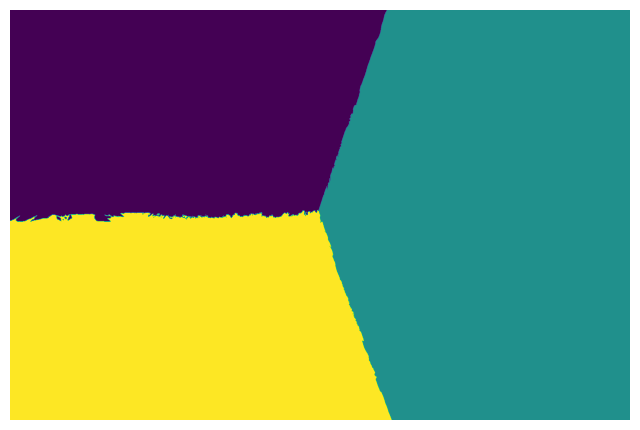

In [20]:
def find_components(image, lmbd, n_clusters):
    # Получаем размеры изображения
    rows, cols, channels = image.shape

    # Инициализируем массив для хранения признаков пикселей
    pixels_features = np.zeros((rows * cols, channels + 2))

    # Заполняем массив признаками пикселей
    for i in range(rows):
        for j in range(cols):
            r, g, b = image[i, j]
            pixels_features[i * cols + j] = [lmbd * i, lmbd * j, r, g, b]

    # Применяем KMeans для кластеризации пикселей
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels_features)

    # Восстанавливаем изображение после кластеризации
    segmented_image = labels.reshape(rows, cols)

    # Визуализация результата сегментации
    plt.figure(figsize=(8, 8))
    plt.imshow(segmented_image, cmap='viridis')
    plt.axis('off')
    plt.show()

# Применяем функцию к изображениям
find_components(image1, 0.3, 3)
find_components(image2, 1.5, 3)

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

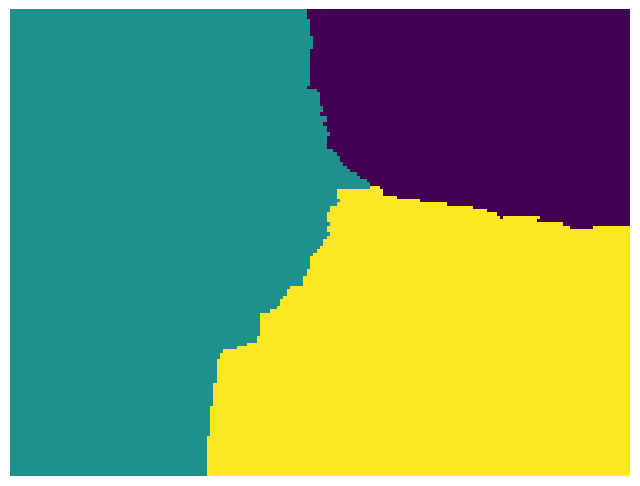

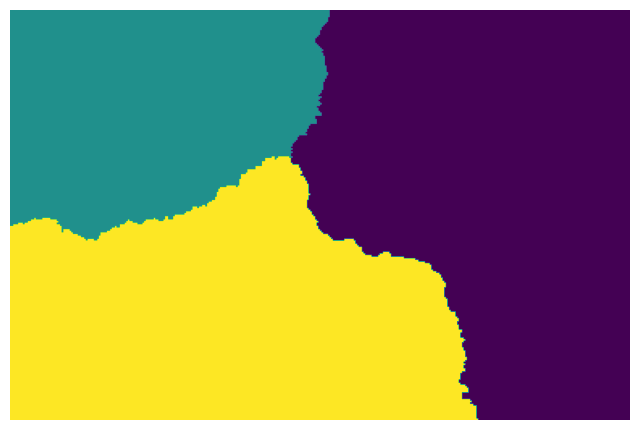

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.transform import resize
from sklearn.feature_extraction import image as sklearn_image
from sklearn.cluster import SpectralClustering

def spectral_segmentation(image_path, n_clusters, resize_factor=0.2):  # Уменьшенный resize_factor
    # Загружаем изображение и приводим его к серому цвету
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)

    # Сжимаем изображение для ускорения обработки
    image_resized = resize(image_gray, (int(image_gray.shape[0] * resize_factor), int(image_gray.shape[1] * resize_factor)), anti_aliasing=True)

    # Преобразуем изображение в граф
    graph = sklearn_image.img_to_graph(image_resized)

    # Применяем экспоненциальное преобразование к весам рёбер графа
    beta = 5
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / image_resized.std()) + eps

    # Применяем спектральную кластеризацию
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans', random_state=1)  # Изменено assign_labels
    labels = spectral.fit_predict(graph)

    # Восстанавливаем размер изображения до исходного
    labels = labels.reshape(image_resized.shape)

    # Визуализация результата сегментации
    plt.figure(figsize=(8, 8))
    plt.imshow(labels, cmap='viridis')
    plt.axis('off')
    plt.show()

# Применяем функцию к изображениям
spectral_segmentation("duck.jpg", n_clusters=3)
spectral_segmentation("owls.jpg", n_clusters=3)

Визуализируйте результаты сегментации (аналогично рисунку выше) для обоих методов.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


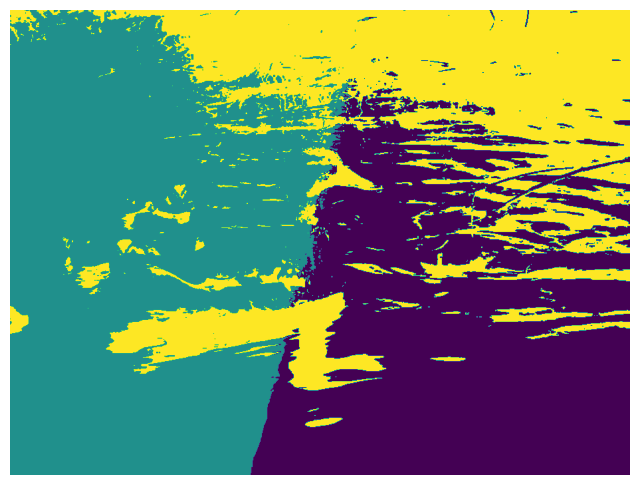

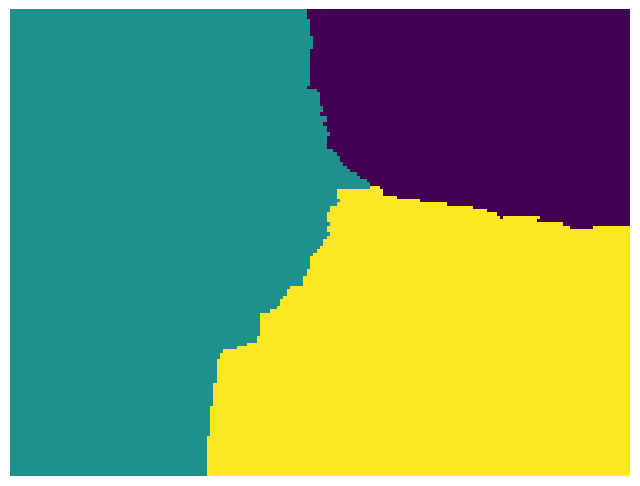

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


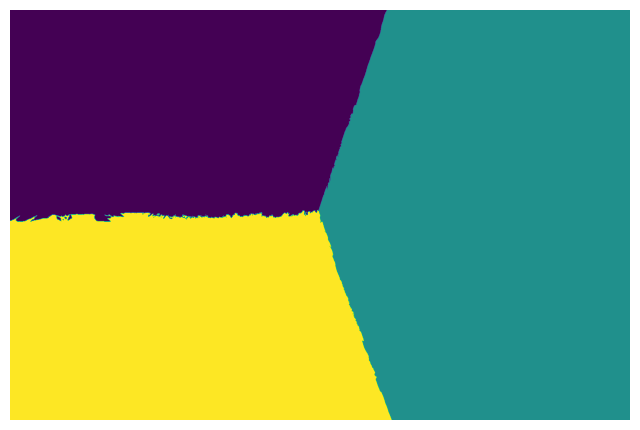

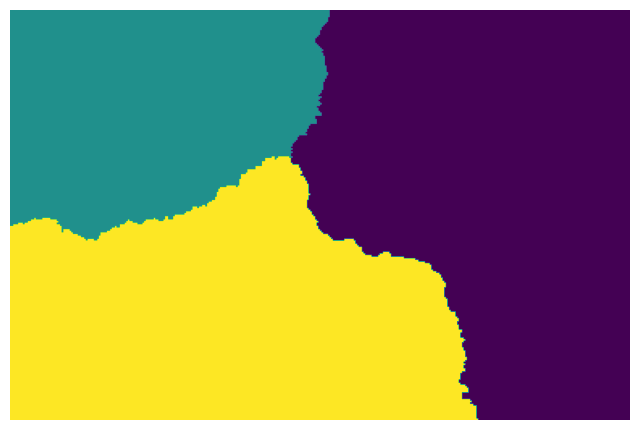

In [24]:
import skimage.io
import skimage.color
import skimage.transform

# Чтение и уменьшение размера изображений
image1 = skimage.io.imread("duck.jpg")
image2 = skimage.io.imread("owls.jpg")

# Перевод в серый цвет и уменьшение размера
image11 = skimage.color.rgb2gray(image1)
rows, cols = image1.shape[0], image1.shape[1]
image11 = skimage.transform.resize(image11, (int(0.5 * rows), int(0.5 * cols)))

image22 = skimage.color.rgb2gray(image2)
rows, cols = image2.shape[0], image2.shape[1]
image22 = skimage.transform.resize(image22, (int(0.5 * rows), int(0.5 * cols)))

# Применяем функции сегментации к уменьшенным серым изображениям
find_components(image1, 0.3, 3)
spectral_segmentation("duck.jpg", n_clusters=3)

find_components(image2, 1.5, 3)
spectral_segmentation("owls.jpg", n_clusters=3)

Поэкспериментируйте с параметрами алгоритмов. Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


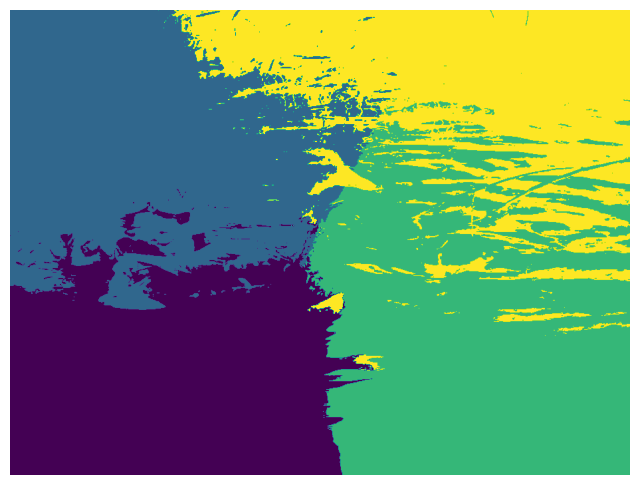

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


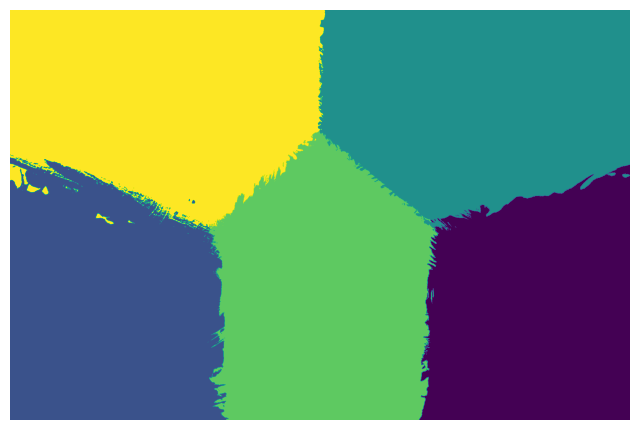

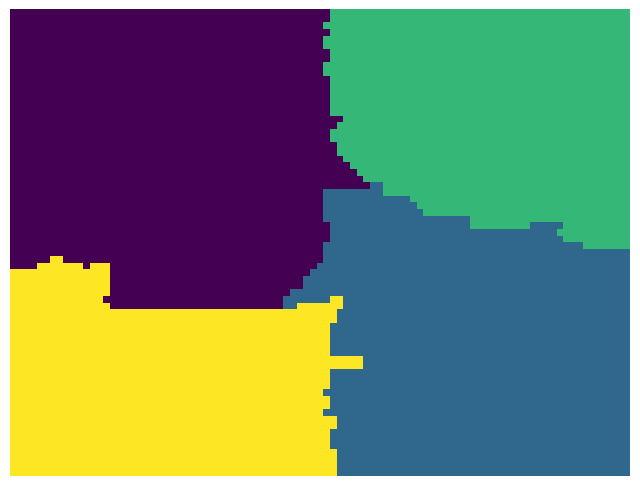

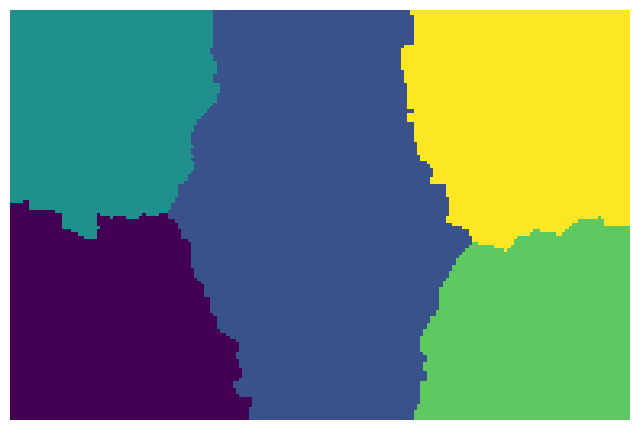

In [25]:
# Экспериментирование с параметрами для KMeans
find_components(image1, 0.5, 4)  # Изменённый параметр lmbd и количество кластеров
find_components(image2, 0.8, 5)

# Экспериментирование с параметрами для спектральной сегментации
spectral_segmentation("duck.jpg", n_clusters=4, resize_factor=0.1)  # Изменённое количество кластеров и resize_factor
spectral_segmentation("owls.jpg", n_clusters=5, resize_factor=0.1)

 Спектральная кластеризация может лучше выделять контуры объектов на некоторых изображениях за счет учета глобальных структурных связностей, но она также может быть более вычислительно затратной. KMeans быстрее и проще в реализации, но может быть менее точным при выделении сложных структур.